In [1]:
# -*- coding: utf-8 -*-
from __future__ import (
    division,
    print_function,
)

import skimage.data
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
#import selectivesearch
from PIL import Image
import numpy as np


def main():
    
    # loading astronaut image
    #img = skimage.data.astronaut()
    
    img = np.array(Image.open("samples/lunch.jpg"))

    # perform selective search
    img_lbl, regions = selective_search_local(
        img, scale=500, sigma=0.9, min_size=10)

    candidates = set()
    for r in regions:
        # excluding same rectangle (with different segments)
        if r['rect'] in candidates:
            continue
        # excluding regions smaller than 2000 pixels
        if r['size'] < 2000:
            continue
        # distorted rects
        x, y, w, h = r['rect']
        if w / h > 1.2 or h / w > 1.2:
            continue
        candidates.add(r['rect'])

    # draw rectangles on the original image
    fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(6, 6))
    ax.imshow(img)
    for x, y, w, h in candidates:
        print(x, y, w, h)
        rect = mpatches.Rectangle(
            (x, y), w, h, fill=False, edgecolor='red', linewidth=1)
        ax.add_patch(rect)

    plt.show()
    
    return img, img_lbl, regions

def get_spaced_colors(N):
    max_value = 16581375 #255**3
    interval = int(max_value / N)
    colors = [hex(I)[2:].zfill(6) for I in range(0, max_value, interval)]

    return [(int(i[:2], 16), int(i[2:4], 16), int(i[4:], 16)) for i in colors]

# -*- coding: utf-8 -*-
from __future__ import division

import skimage.io
import skimage.feature
import skimage.color
import skimage.transform
import skimage.util
import skimage.segmentation
import numpy


# "Selective Search for Object Recognition" by J.R.R. Uijlings et al.
#
#  - Modified version with LBP extractor for texture vectorization


def _generate_segments(im_orig, scale, sigma, min_size):
    """
        segment smallest regions by the algorithm of Felzenswalb and
        Huttenlocher
    """

    # open the Image
    im_mask = skimage.segmentation.felzenszwalb(
        skimage.util.img_as_float(im_orig), scale=scale, sigma=sigma,
        min_size=min_size)

    # merge mask channel to the image as a 4th channel
    im_orig = numpy.append(
        im_orig, numpy.zeros(im_orig.shape[:2])[:, :, numpy.newaxis], axis=2)
    im_orig[:, :, 3] = im_mask

    return im_orig


def _sim_colour(r1, r2):
    """
        calculate the sum of histogram intersection of colour
    """
    return sum([min(a, b) for a, b in zip(r1["hist_c"], r2["hist_c"])])


def _sim_texture(r1, r2):
    """
        calculate the sum of histogram intersection of texture
    """
    return sum([min(a, b) for a, b in zip(r1["hist_t"], r2["hist_t"])])


def _sim_size(r1, r2, imsize):
    """
        calculate the size similarity over the image
    """
    return 1.0 - (r1["size"] + r2["size"]) / imsize


def _sim_fill(r1, r2, imsize):
    """
        calculate the fill similarity over the image
    """
    bbsize = (
        (max(r1["max_x"], r2["max_x"]) - min(r1["min_x"], r2["min_x"]))
        * (max(r1["max_y"], r2["max_y"]) - min(r1["min_y"], r2["min_y"]))
    )
    return 1.0 - (bbsize - r1["size"] - r2["size"]) / imsize


def _calc_sim(r1, r2, imsize):
    return (_sim_colour(r1, r2) + _sim_texture(r1, r2)
            + _sim_size(r1, r2, imsize) + _sim_fill(r1, r2, imsize))


def _calc_colour_hist(img):
    """
        calculate colour histogram for each region

        the size of output histogram will be BINS * COLOUR_CHANNELS(3)

        number of bins is 25 as same as [uijlings_ijcv2013_draft.pdf]

        extract HSV
    """

    BINS = 25
    hist = numpy.array([])

    for colour_channel in (0, 1, 2):

        # extracting one colour channel
        c = img[:, colour_channel]

        # calculate histogram for each colour and join to the result
        hist = numpy.concatenate(
            [hist] + [numpy.histogram(c, BINS, (0.0, 255.0))[0]])

    # L1 normalize
    hist = hist / len(img)

    return hist


def _calc_texture_gradient(img):
    """
        calculate texture gradient for entire image

        The original SelectiveSearch algorithm proposed Gaussian derivative
        for 8 orientations, but we use LBP instead.

        output will be [height(*)][width(*)]
    """
    ret = numpy.zeros((img.shape[0], img.shape[1], img.shape[2]))

    for colour_channel in (0, 1, 2):
        ret[:, :, colour_channel] = skimage.feature.local_binary_pattern(
            img[:, :, colour_channel], 8, 1.0)

    return ret


def _calc_texture_hist(img):
    """
        calculate texture histogram for each region

        calculate the histogram of gradient for each colours
        the size of output histogram will be
            BINS * ORIENTATIONS * COLOUR_CHANNELS(3)
    """
    BINS = 10

    hist = numpy.array([])

    for colour_channel in (0, 1, 2):

        # mask by the colour channel
        fd = img[:, colour_channel]

        # calculate histogram for each orientation and concatenate them all
        # and join to the result
        hist = numpy.concatenate(
            [hist] + [numpy.histogram(fd, BINS, (0.0, 1.0))[0]])

    # L1 Normalize
    hist = hist / len(img)

    return hist


def _extract_regions(img):

    R = {}

    # get hsv image
    hsv = skimage.color.rgb2hsv(img[:, :, :3])

    # pass 1: count pixel positions
    for y, i in enumerate(img):

        for x, (r, g, b, l) in enumerate(i):

            # initialize a new region
            if l not in R:
                R[l] = {
                    "min_x": 0xffff, "min_y": 0xffff,
                    "max_x": 0, "max_y": 0, "labels": [l]}

            # bounding box
            if R[l]["min_x"] > x:
                R[l]["min_x"] = x
            if R[l]["min_y"] > y:
                R[l]["min_y"] = y
            if R[l]["max_x"] < x:
                R[l]["max_x"] = x
            if R[l]["max_y"] < y:
                R[l]["max_y"] = y

    # pass 2: calculate texture gradient
    tex_grad = _calc_texture_gradient(img)

    # pass 3: calculate colour histogram of each region
    for k, v in list(R.items()):

        # colour histogram
        masked_pixels = hsv[:, :, :][img[:, :, 3] == k]
        R[k]["size"] = len(masked_pixels / 4)
        R[k]["hist_c"] = _calc_colour_hist(masked_pixels)

        # texture histogram
        R[k]["hist_t"] = _calc_texture_hist(tex_grad[:, :][img[:, :, 3] == k])

    return R


def _extract_neighbours(regions):

    def intersect(a, b):
        if (a["min_x"] < b["min_x"] < a["max_x"]
                and a["min_y"] < b["min_y"] < a["max_y"]) or (
            a["min_x"] < b["max_x"] < a["max_x"]
                and a["min_y"] < b["max_y"] < a["max_y"]) or (
            a["min_x"] < b["min_x"] < a["max_x"]
                and a["min_y"] < b["max_y"] < a["max_y"]) or (
            a["min_x"] < b["max_x"] < a["max_x"]
                and a["min_y"] < b["min_y"] < a["max_y"]):
            return True
        return False

    R = list(regions.items())
    neighbours = []
    for cur, a in enumerate(R[:-1]):
        for b in R[cur + 1:]:
            if intersect(a[1], b[1]):
                neighbours.append((a, b))

    return neighbours


def _merge_regions(r1, r2):
    new_size = r1["size"] + r2["size"]
    rt = {
        "min_x": min(r1["min_x"], r2["min_x"]),
        "min_y": min(r1["min_y"], r2["min_y"]),
        "max_x": max(r1["max_x"], r2["max_x"]),
        "max_y": max(r1["max_y"], r2["max_y"]),
        "size": new_size,
        "hist_c": (
            r1["hist_c"] * r1["size"] + r2["hist_c"] * r2["size"]) / new_size,
        "hist_t": (
            r1["hist_t"] * r1["size"] + r2["hist_t"] * r2["size"]) / new_size,
        #####can there be two pairs of labels whose sum is equal? that would mean overwriting!
        #####no problem. the labels are lists to start with, so they just get appended.
        "labels": r1["labels"] + r2["labels"]
    }
    return rt


def selective_search_local(
        im_orig, scale=1.0, sigma=0.8, min_size=50):
    '''Selective Search

    Parameters
    ----------
        im_orig : ndarray
            Input image
        scale : int
            Free parameter. Higher means larger clusters in felzenszwalb segmentation.
        sigma : float
            Width of Gaussian kernel for felzenszwalb segmentation.
        min_size : int
            Minimum component size for felzenszwalb segmentation.
    Returns
    -------
        img : ndarray
            image with region label
            region label is stored in the 4th value of each pixel [r,g,b,(region)]
        regions : array of dict
            [
                {
                    'rect': (left, top, width, height),
                    'labels': [...],
                    'size': component_size
                },
                ...
            ]
    '''
    assert im_orig.shape[2] == 3, "3ch image is expected"

    # load image and get smallest regions
    # region label is stored in the 4th value of each pixel [r,g,b,(region)]
    img = _generate_segments(im_orig, scale, sigma, min_size)

    import matplotlib.pyplot as plt
    fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(6, 6))
    ax.imshow(img)

    if img is None:
        return None, {}

    imsize = img.shape[0] * img.shape[1]
    
    R = _extract_regions(img)

    # extract neighbouring information
    neighbours = _extract_neighbours(R)

    # calculate initial similarities
    S = {}
    for (ai, ar), (bi, br) in neighbours:
        S[(ai, bi)] = _calc_sim(ar, br, imsize)

    # hierarchal search
    while S != {}:

        # get highest similarity
        i, j = sorted(S.items(), key=lambda i: i[1])[-1][0]

        # merge corresponding regions
        t = max(R.keys()) + 1.0
        R[t] = _merge_regions(R[i], R[j])

        # mark similarities for regions to be removed
        key_to_delete = []
        for k, v in list(S.items()):
            if (i in k) or (j in k):
                key_to_delete.append(k)

        # remove old similarities of related regions
        for k in key_to_delete:
            del S[k]

        # calculate similarity set with the new region
        for k in [a for a in key_to_delete if a != (i, j)]:
            n = k[1] if k[0] in (i, j) else k[0]
            S[(t, n)] = _calc_sim(R[t], R[n], imsize)

    regions = []
    for k, r in list(R.items()):
        regions.append({
            'rect': (
                r['min_x'], r['min_y'],
                r['max_x'] - r['min_x'], r['max_y'] - r['min_y']),
            'size': r['size'],
            'labels': r['labels']
        })

    return img, regions


0 54 319 327
576 673 98 94
432 283 87 96
154 300 81 79
570 100 453 421
52 384 177 203
576 686 84 81
341 283 215 196
194 62 438 487
0 58 319 323
345 289 167 190
52 382 177 205
576 673 110 94
0 58 319 293
555 100 468 474
154 300 81 81
386 546 192 221
554 232 125 147
104 232 164 172
791 184 87 90
345 289 210 190
341 283 214 196
0 62 682 705
339 269 217 210
64 134 216 200
22 133 97 88


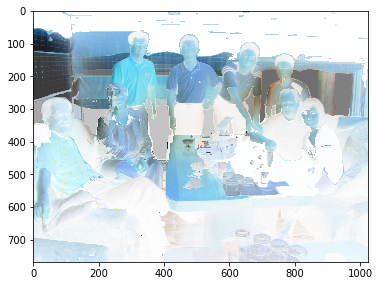

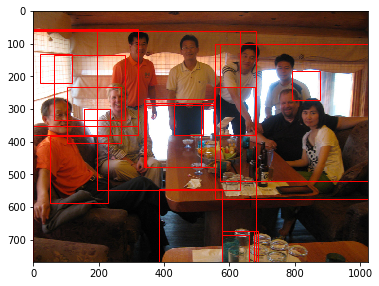

In [2]:
img, img_lbl, regions = main()

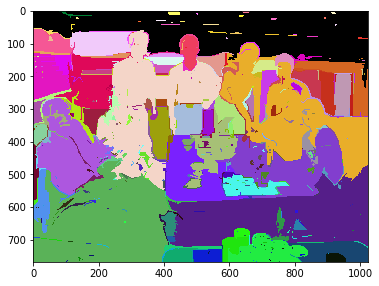

In [3]:
import numpy as np

h = img_lbl.shape[0]
w = img_lbl.shape[1]
seg = np.zeros([h,w,3])

n_colors = len(np.unique(img_lbl[:,:,3]))
unique_colors = get_spaced_colors(n_colors)

for i in range(h):
    for j in range(w):
    
        color_label = int(img_lbl[i][j][3])
        seg[i][j][0]= unique_colors[color_label][0]
        seg[i][j][1]= unique_colors[color_label][1]
        seg[i][j][2]= unique_colors[color_label][2]



        
import matplotlib.pyplot as plt
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(6, 6))
ax.imshow(seg)
plt.show()

In [4]:
img_lbl[170][450]

array([ 164.,  112.,   62.,   24.])

In [5]:
[a, b] = np.where(img_lbl[:,:,3] == 37)

In [6]:
img_lbl[a[100]][b[100]][3]

37.0

In [7]:
img_lbl[100]

array([[ 253.,  254.,  248.,   23.],
       [ 253.,  255.,  254.,   23.],
       [ 254.,  255.,  255.,   23.],
       ..., 
       [  79.,   47.,   32.,    0.],
       [  80.,   48.,   33.,    0.],
       [  81.,   49.,   34.,    0.]])

In [8]:
img_lbl[100][475]

array([ 126.,   61.,   21.,   37.])

In [9]:
min(a), max(a), min(b), max(b)

(77, 184, 449, 505)

In [10]:
regions

[{'labels': [0.0], 'rect': (0, 0, 1023, 239), 'size': 110770},
 {'labels': [1.0], 'rect': (74, 0, 105, 23), 'size': 484},
 {'labels': [2.0], 'rect': (410, 0, 39, 14), 'size': 433},
 {'labels': [3.0], 'rect': (640, 0, 21, 9), 'size': 192},
 {'labels': [4.0], 'rect': (912, 6, 13, 5), 'size': 63},
 {'labels': [5.0], 'rect': (499, 10, 5, 3), 'size': 23},
 {'labels': [6.0], 'rect': (629, 14, 14, 5), 'size': 79},
 {'labels': [7.0], 'rect': (888, 21, 8, 4), 'size': 35},
 {'labels': [8.0], 'rect': (130, 22, 11, 4), 'size': 53},
 {'labels': [9.0], 'rect': (727, 24, 17, 6), 'size': 105},
 {'labels': [10.0], 'rect': (376, 31, 29, 1), 'size': 33},
 {'labels': [11.0], 'rect': (320, 35, 9, 1), 'size': 20},
 {'labels': [12.0], 'rect': (448, 35, 15, 0), 'size': 16},
 {'labels': [13.0], 'rect': (193, 36, 20, 2), 'size': 21},
 {'labels': [14.0], 'rect': (408, 38, 18, 2), 'size': 26},
 {'labels': [15.0], 'rect': (160, 39, 29, 0), 'size': 30},
 {'labels': [16.0], 'rect': (116, 40, 54, 21), 'size': 156},
 

In [11]:
regions

[{'labels': [0.0], 'rect': (0, 0, 1023, 239), 'size': 110770},
 {'labels': [1.0], 'rect': (74, 0, 105, 23), 'size': 484},
 {'labels': [2.0], 'rect': (410, 0, 39, 14), 'size': 433},
 {'labels': [3.0], 'rect': (640, 0, 21, 9), 'size': 192},
 {'labels': [4.0], 'rect': (912, 6, 13, 5), 'size': 63},
 {'labels': [5.0], 'rect': (499, 10, 5, 3), 'size': 23},
 {'labels': [6.0], 'rect': (629, 14, 14, 5), 'size': 79},
 {'labels': [7.0], 'rect': (888, 21, 8, 4), 'size': 35},
 {'labels': [8.0], 'rect': (130, 22, 11, 4), 'size': 53},
 {'labels': [9.0], 'rect': (727, 24, 17, 6), 'size': 105},
 {'labels': [10.0], 'rect': (376, 31, 29, 1), 'size': 33},
 {'labels': [11.0], 'rect': (320, 35, 9, 1), 'size': 20},
 {'labels': [12.0], 'rect': (448, 35, 15, 0), 'size': 16},
 {'labels': [13.0], 'rect': (193, 36, 20, 2), 'size': 21},
 {'labels': [14.0], 'rect': (408, 38, 18, 2), 'size': 26},
 {'labels': [15.0], 'rect': (160, 39, 29, 0), 'size': 30},
 {'labels': [16.0], 'rect': (116, 40, 54, 21), 'size': 156},
 

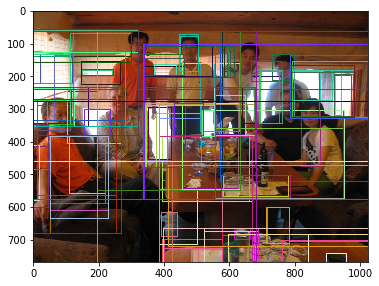

In [12]:
candidates = []
for r in regions:
    # excluding same rectangle (with different segments)
    #if r['rect'] in candidates:
        #continue
    # excluding regions smaller than 2000 pixels
    if r['size'] < 1000:
        continue
    # distorted rects
    x, y, w, h = r['rect']
    if w / h > 10 or h / w > 10:
        continue
    candidates.append([r['rect'], r['labels']])


# draw rectangles on the original image
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(6, 6))
ax.imshow(img)
inx = 0 
for rectangle, label in candidates:
    #print(x, y, w, h)
    x,y,w,h = rectangle
    
    delt = 0
    for l in label:     
        #unique_colors[]
        this_label = int(l)
        edgecolor = [unique_colors[this_label][0]/255, unique_colors[this_label][1]/255, unique_colors[this_label][2]/255]
        #add slight offset to visualize each segment label that consitutes this region
        rect = mpatches.Rectangle((x+delt, y+delt), w, h, fill=False, edgecolor=edgecolor, linewidth=1)
        #delt = delt + 1
        ax.add_patch(rect)

plt.show()

In [13]:
for rectangle, label in candidates:
    print(len(label))

1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
2
3
2
2
2
2
3
3
2
4
5
2
3
3
6
7
3
4
2
8
2
6
2
2
4
2
2
3
2
3
4
7
2
4
2
5
2
2
9
5
2
3
8
3
3
3
9
10
3
2
4
4
2
10
5
2
11
6
6
2
13
14
4
5
3
17
2
7
7
8
11
3
2
3
18
8
9
12
8
5
3
7
13
3
11
8
3
12
2
14
2
10
4
9
14
15
3
6
7
8
4
2
11
20
3
2
16
3
15
12
3
9
4
24
16
18
5
4
2
19
3
3
4
4
7
9
10
20
3
5
9
6
14
25
3
10
5
6
11
5
12
7
4
4
8
7
5
2
10
17
4
13
3
5
3
4
6
11
14
2
13
3
6
15
14
26
8
10
4
4
7
5
6
8
29
30
16
15
18
22
23
5
9
12
8
11
12
32
21
16
13
12
10
3
24
9
6
33
13
4
5
10
11
13
49
4
12
14
15
16
7
6
17
17
12
11
12
30
31
4
8
32
13
30
16
21
14
9
22
15
16
21
22
13
14
8
30
24
38
39
41
31
31
15
16
5
11
6
32
34
17
35
18
12
33
37
49
20
21
52
2
50
34
35
53
36
22
37
26
18
51
54
38
32
33
21
23
39
55
4
5
34
40
56
52
5
57
59
10
60
61
62
86
41
17
27
18
42
9
12
13
5
5
47
63
14
42
28
29
19
64
20
30
10
33
38
65
21
66
67
31
68
22
23
43
32
69
24
25
70
33
71
72
34
73
74
35
36
37
75
22
38
76
77
26
78
79
3

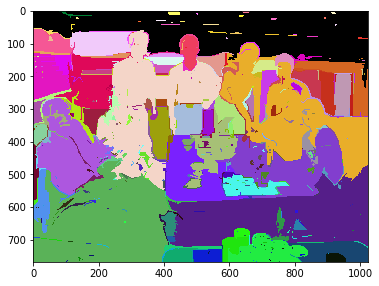

In [14]:
import numpy as np

h = img_lbl.shape[0]
w = img_lbl.shape[1]
seg = np.zeros([h,w,3])

n_colors = len(np.unique(img_lbl[:,:,3]))
unique_colors = get_spaced_colors(n_colors)

for i in range(h):
    for j in range(w):
    
        color_label = int(img_lbl[i][j][3])
        seg[i][j][0]= unique_colors[color_label][0]
        seg[i][j][1]= unique_colors[color_label][1]
        seg[i][j][2]= unique_colors[color_label][2]



        
import matplotlib.pyplot as plt
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(6, 6))
ax.imshow(seg)
plt.show()

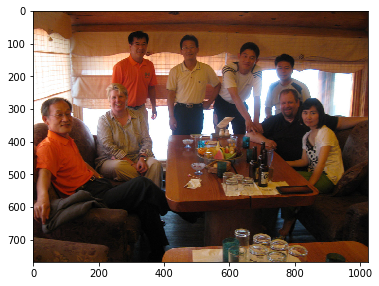

In [15]:
from PIL import Image
import numpy as np
jpgfile = np.array(Image.open("samples/sample_!.jpg"))


import matplotlib.pyplot as plt
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(6, 6))
ax.imshow(img)
plt.show()
